In [1]:
!pip install scikit-learn
!pip install pillow
!pip install matplotlib

In [2]:
import pandas as pd
import tensorflow
import PIL
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications.mobilenet_v2 import MobileNetV2

In [3]:
base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [4]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='sigmoid'))

In [5]:
data=pd.read_csv("C:/Users/karan/Desktop/6th sem project/archive (1)/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [6]:
X.sample(5)

,image_full_name,dx,lesion_id
4367,ISIC_0026896.jpg,nv,HAM_0002328
380,ISIC_0032200.jpg,bkl,HAM_0002169
4370,ISIC_0026505.jpg,nv,HAM_0003047
1387,ISIC_0024875.jpg,mel,HAM_0007617
5942,ISIC_0026161.jpg,nv,HAM_0007407


In [7]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(X,Y, test_size=0.17, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.17, random_state=42)

In [8]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx']) 
val['label']=name_as_indexes_train

In [10]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx']) 
test['label']=name_as_indexes_test

In [11]:
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.00) 

In [12]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory="C:/Users/karan/Desktop/6th sem project/archive (1)/HAM1000_images",
                                                shuffle=True,class_mode="categorical",target_size=(224,224))

Found 6898 validated image filenames belonging to 7 classes.


In [13]:
test_generator=ImageDataGenerator(rescale = 1./255,rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.02)

In [14]:
test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory="C:/Users/karan/Desktop/6th sem project/archive (1)/HAM1000_images",
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(224,224))

Found 1703 validated image filenames.


In [15]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                            directory="C:/Users/karan/Desktop/6th sem project/archive (1)/HAM1000_images",
                                            batch_size=64,shuffle=False,class_mode="categorical",target_size=(224,224))

Found 1414 validated image filenames belonging to 7 classes.


In [16]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [17]:
from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import SGD
sgd = tensorflow.keras.optimizers.SGD(learning_rate = 0.01, clipvalue = 0.5)
model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])

In [18]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=20,callbacks=[learning_control])

C:\Users\karan\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
215/215 [==============================] - 121s 527ms/step - loss: 1.0663 - accuracy: 0.6518 - val_loss: 1.8155 - val_accuracy: 0.6733
Epoch 2/20
215/215 [==============================] - 102s 473ms/step - loss: 0.8275 - accuracy: 0.7040 - val_loss: 1.3959 - val_accuracy: 0.6733
Epoch 3/20
215/215 [==============================] - 102s 473ms/step - loss: 0.7512 - accuracy: 0.7316 - val_loss: 2.2429 - val_accuracy: 0.6733
Epoch 4/20
215/215 [==============================] - 102s 473ms/step - loss: 0.6697 - accuracy: 0.7569 - val_loss: 3.2006 - val_accuracy: 0.6733
Epoch 5/20
215/215 [==============================] - 102s 473ms/step - loss: 0.6088 - accuracy: 0.7798 - val_loss: 2.0236 - val_accuracy: 0.6733
Epoch 6/20
215/215 [==============================] - 103s 476ms/step - loss: 0.5564 - accuracy: 0.8027 - val_loss: 1.1291 - val_accuracy: 0.6903
Epoch 7/20
215/215 [==============================] - 102s 474ms/step - loss: 0.5091 - accuracy: 0.8209 - val_loss: 2.6525 -

In [19]:
model.save('model12345.h5')

C:\Users\karan\anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


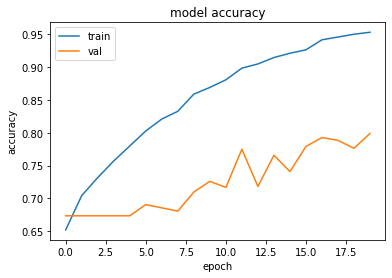

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

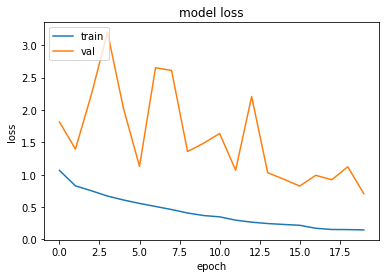

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

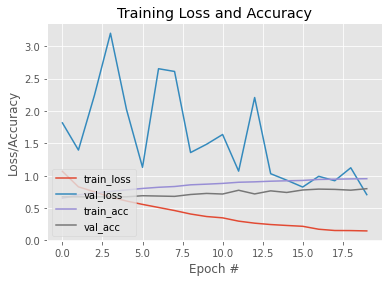

In [23]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [24]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

C:\Users\karan\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1703/1703 [==============================] - 26s 15ms/step


In [25]:
c=np.where(y_pred == name_as_indexes_test)

In [26]:
np.count_nonzero(c)

1290

In [27]:
print("Test Accuracy :",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy : 75.74867880211391


In [28]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(name_as_indexes_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.60      0.65      0.62        62
           1       0.57      0.79      0.66        77
           2       0.57      0.76      0.65       201
           3       0.61      0.46      0.52        24
           4       0.43      0.45      0.44       191
           5       0.91      0.82      0.86      1128
           6       0.61      1.00      0.75        20

    accuracy                           0.76      1703
   macro avg       0.61      0.70      0.64      1703
weighted avg       0.78      0.76      0.77      1703



In [29]:
model.save("model12345.h5")

C:\Users\karan\anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
